# __MACAD GRAPH MACHINE LEARNING__
***
### James Foo and Andres Roncal

This notebook explore the relationship between property development and eviction rates in Manhattan, NY.

#### IMPORT DEPENDENCIES

In [105]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
import momepy as mp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
# import nx_altair as nxa
import shapely.geometry as geom
from itertools import islice
from collections import Counter
import sklearn as sk
from sklearn.cluster import KMeans
from tqdm import tqdm
import torch
import dgl

### 1. CREATE GRAPH OF MANHATTAN WITH OSMNX
***

In [11]:
place_name = "Manhattan Island, New York, United States"
G = ox.graph_from_place(place_name, network_type= 'drive', simplify = True)

In [12]:
area = ox.geocode_to_gdf(place_name)

### 2. ADD FEATURES TO GRAPH
***

#### FEATURE 1: EVICTIONS

In [16]:
#Load eviction data and filter data for Manhattan only
eviction_data = open(r"C:\Users\jfoo\OneDrive - tvsdesign\Desktop\MACAD\AIA\Studio\AIA-GML-James-Andres\Data\Evictions_20240516.csv")
eviction_df = pd.read_csv(eviction_data)
manhattan_evictions = eviction_df[eviction_df['BOROUGH'] == 'MANHATTAN']
clean_evictions = manhattan_evictions.dropna(subset = ['Latitude'])

In [17]:
geometry = gpd.points_from_xy(clean_evictions['Longitude'], clean_evictions['Latitude'])
manhattan_evictions_gdf = gpd.GeoDataFrame(clean_evictions, geometry= geometry)
manhattan_evictions_gdf.set_crs(epsg= 4326)

Court Index Number  Docket Number               Eviction Address  \
3               74670/16           61667        535 WEST 110TH STREE T   
10             311118/22            6085  2915 FREDERICK DOUGLASS BLVD   
14              59878/19           18419        620 WEST 172ND STREE T   
36              82266/16            9013              220 CABRINI BLVD   
39             N60311/19           97948        267 WEST 146TH STREE T   
...                  ...             ...                           ...   
91169           21087/18           34034             442 EAST 105TH ST   
91195          080658/17           80051         106-108 WEST 109TH ST   
91196           65769/19          357421          243 EAST 83RD STREET   
91197           65769/19          357421          243 EAST 83RD STREET   
91199          310455/23          121412            214 AUDUBON AVENUE   

      Eviction Apartment Number Executed Date Marshal First Name  \
3                            3A    05/04/2017             Justin   
10                           4C    03/05/2024              David   
14                           4A    08/13/2019             George   
36                           3D    01/30/2018             George   
39                           16    10/03/2019             Ileana   
...                         ...           ...                ...   
91169                       05B    05/07/2019              Bruce   
91195                        3C    03/02/2018              Henry   
91196                        5C    12/12/2019             Thomas   
91197                        5C    12/12/2019             Thomas   
91199                        46    10/05/2023             Justin   

      Marshal Last Name Residential/Commercial    BOROUGH  Eviction Postcode  \
3              Grossman            Residential  MANHATTAN              10025   
10                Smith            Residential  MANHATTAN              10039   
14          Essock, Jr.            Residential  MANHATTAN              10032   
36          Essock, Jr.            Residential  MANHATTAN              10033   
39               Rivera            Residential  MANHATTAN              10039   
...                 ...                    ...        ...                ...   
91169              Kemp            Residential  MANHATTAN              10029   
91195             Daley            Residential  MANHATTAN              10025   
91196               Bia            Residential  MANHATTAN              10028   
91197               Bia            Residential  MANHATTAN              10028   
91199          Grossman            Residential  MANHATTAN              10033   

       ... Eviction/Legal Possession   Latitude  Longitude  Community Board  \
3      ...                Possession  40.803795 -73.965797              9.0   
10     ...                Possession  40.828736 -73.937611             10.0   
14     ...                Possession  40.844060 -73.939327             12.0   
36     ...                Possession  40.854901 -73.938490             12.0   
39     ...                Possession  40.823075 -73.940380             10.0   
...    ...                       ...        ...        ...              ...   
91169  ...                  Eviction  40.788265 -73.938952             11.0   
91195  ...                Possession  40.801398 -73.962010              7.0   
91196  ...                Possession  40.776451 -73.954395              8.0   
91197  ...                Possession  40.776451 -73.954395              8.0   
91199  ...                Possession  40.845364 -73.934812             12.0   

       Council District  Census Tract        BIN           BBL  \
3                   7.0         199.0  1056904.0  1.018820e+09   
10                  9.0       23502.0  1060897.0  1.020470e+09   
14                 10.0         253.0  1063486.0  1.021420e+09   
36                 10.0         275.0  1064369.0  1.021790e+09   
39                  9.0         234.0  1060499.0  1.020320e+

In [18]:
eviction_gdf_points = manhattan_evictions_gdf[manhattan_evictions_gdf['geometry'].type == 'Point']
eviction_gdf_points.head()

Court Index Number  Docket Number               Eviction Address  \
3            74670/16           61667        535 WEST 110TH STREE T   
10          311118/22            6085  2915 FREDERICK DOUGLASS BLVD   
14           59878/19           18419        620 WEST 172ND STREE T   
36           82266/16            9013              220 CABRINI BLVD   
39          N60311/19           97948        267 WEST 146TH STREE T   

   Eviction Apartment Number Executed Date Marshal First Name  \
3                         3A    05/04/2017             Justin   
10                        4C    03/05/2024              David   
14                        4A    08/13/2019             George   
36                        3D    01/30/2018             George   
39                        16    10/03/2019             Ileana   

   Marshal Last Name Residential/Commercial    BOROUGH  Eviction Postcode  \
3           Grossman            Residential  MANHATTAN              10025   
10             Smith            Residential  MANHATTAN              10039   
14       Essock, Jr.            Residential  MANHATTAN              10032   
36       Essock, Jr.            Residential  MANHATTAN              10033   
39            Rivera            Residential  MANHATTAN              10039   

    ... Eviction/Legal Possession   Latitude  Longitude  Community Board  \
3   ...                Possession  40.803795 -73.965797              9.0   
10  ...                Possession  40.828736 -73.937611             10.0   
14  ...                Possession  40.844060 -73.939327             12.0   
36  ...                Possession  40.854901 -73.938490             12.0   
39  ...                Possession  40.823075 -73.940380             10.0   

    Council District  Census Tract        BIN           BBL  \
3                7.0         199.0  1056904.0  1.018820e+09   
10               9.0       23502.0  1060897.0  1.020470e+09   
14              10.0         253.0  1063486.0  1.021420e+09   
36              10.0         275.0  1064369.0  1.021790e+09   
39               9.0         234.0  1060499.0  1.020320e+09   

                                  NTA                    geometry  
3                 Morningside Heights  POINT (-73.96580 40.80380)  
10  Central Harlem North-Polo Grounds  POINT (-73.93761 40.82874)  
14           Washington Heights South  POINT (-73.93933 40.84406)  
36           Washington Heights North  POINT (-73.93849 40.85490)  
39  Central Harlem North-Polo Grounds  POINT (-73.94038 40.82308)  

[5 rows x 21 columns]

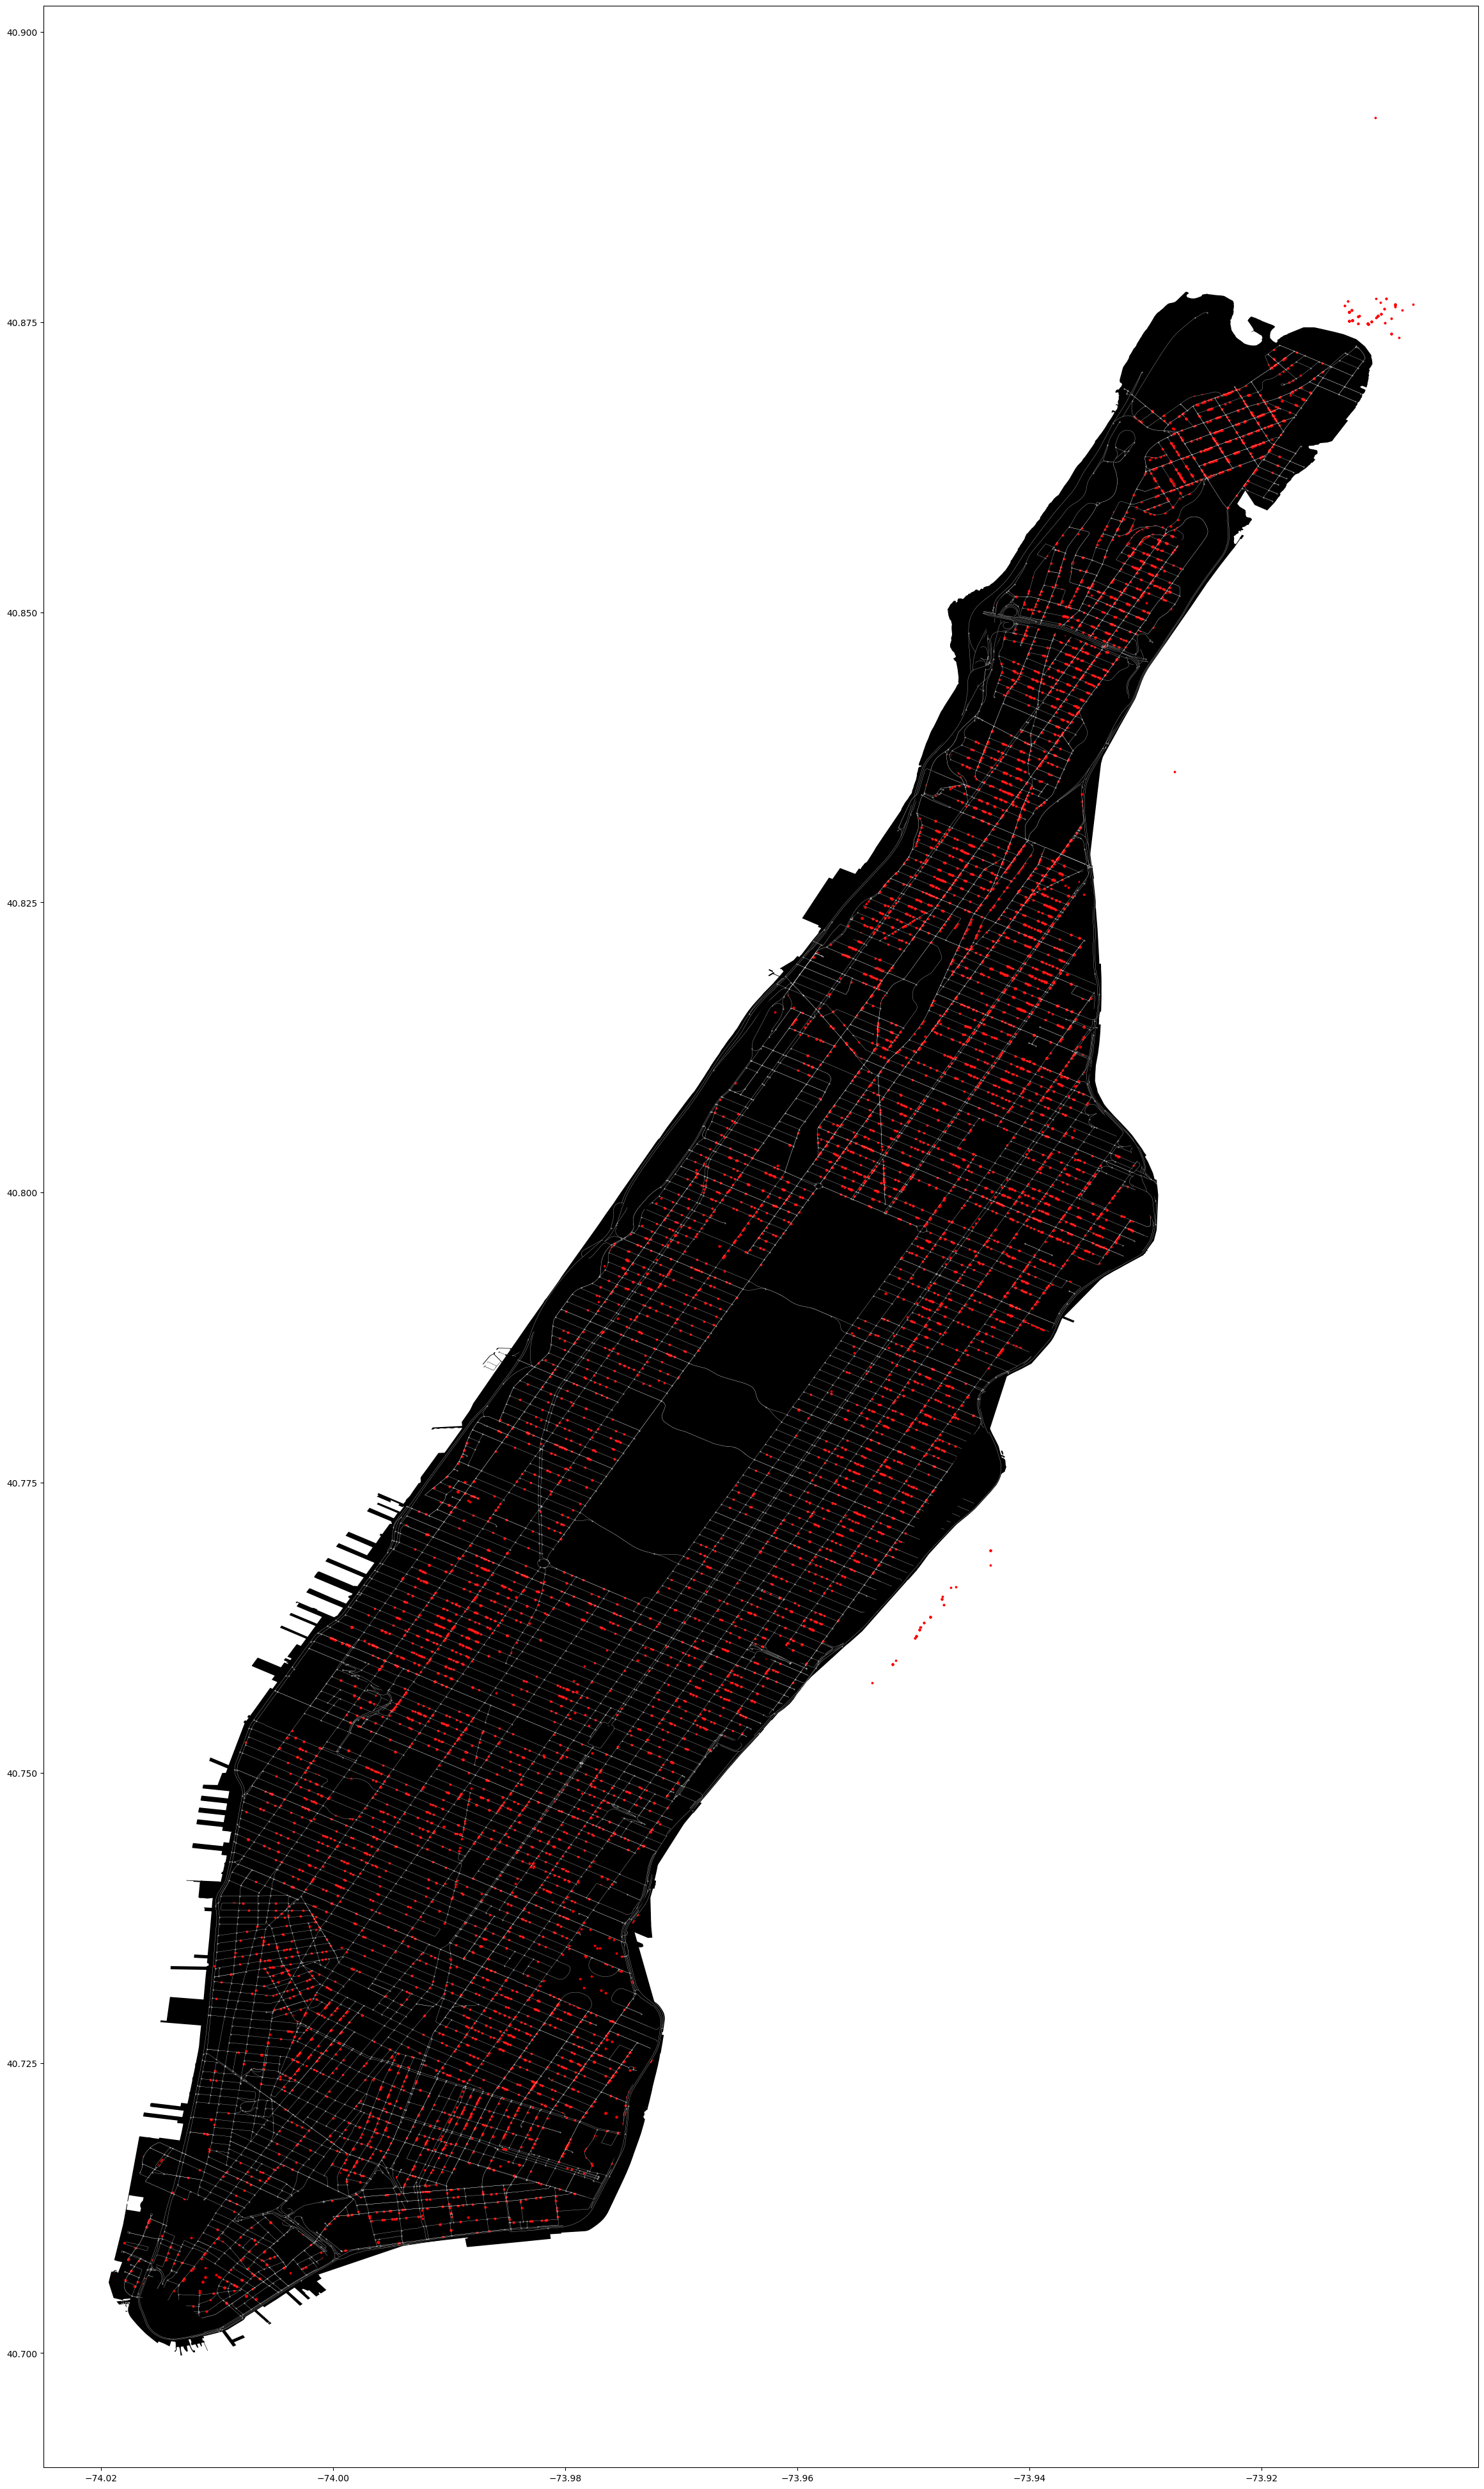

In [78]:
nodes, edges = ox.graph_to_gdfs(G)
fig, ax = plt.subplots(figsize=(30,50))
area.plot(ax = ax, facecolor = 'black')
edges.plot(ax = ax, linewidth = 0.2, edgecolor = 'white', facecolor = 'black')
nodes.plot(ax= ax, color = 'white', markersize = .1)
eviction_gdf_points.plot(ax= ax, markersize = 3, color = 'red')

plt.show()

In [79]:
#Count number of evicictions for each edge
close_edges = ox.distance.nearest_edges(G, eviction_gdf_points['geometry'].x, eviction_gdf_points['geometry'].y)
eviction_count = Counter(close_edges)
evictions = []

#Assign value to each edge
for i in edges.index:
    eviction = eviction_count[edges.loc[i].name]
    evictions.append(eviction)

max(evictions)
edges['evictions'] = evictions

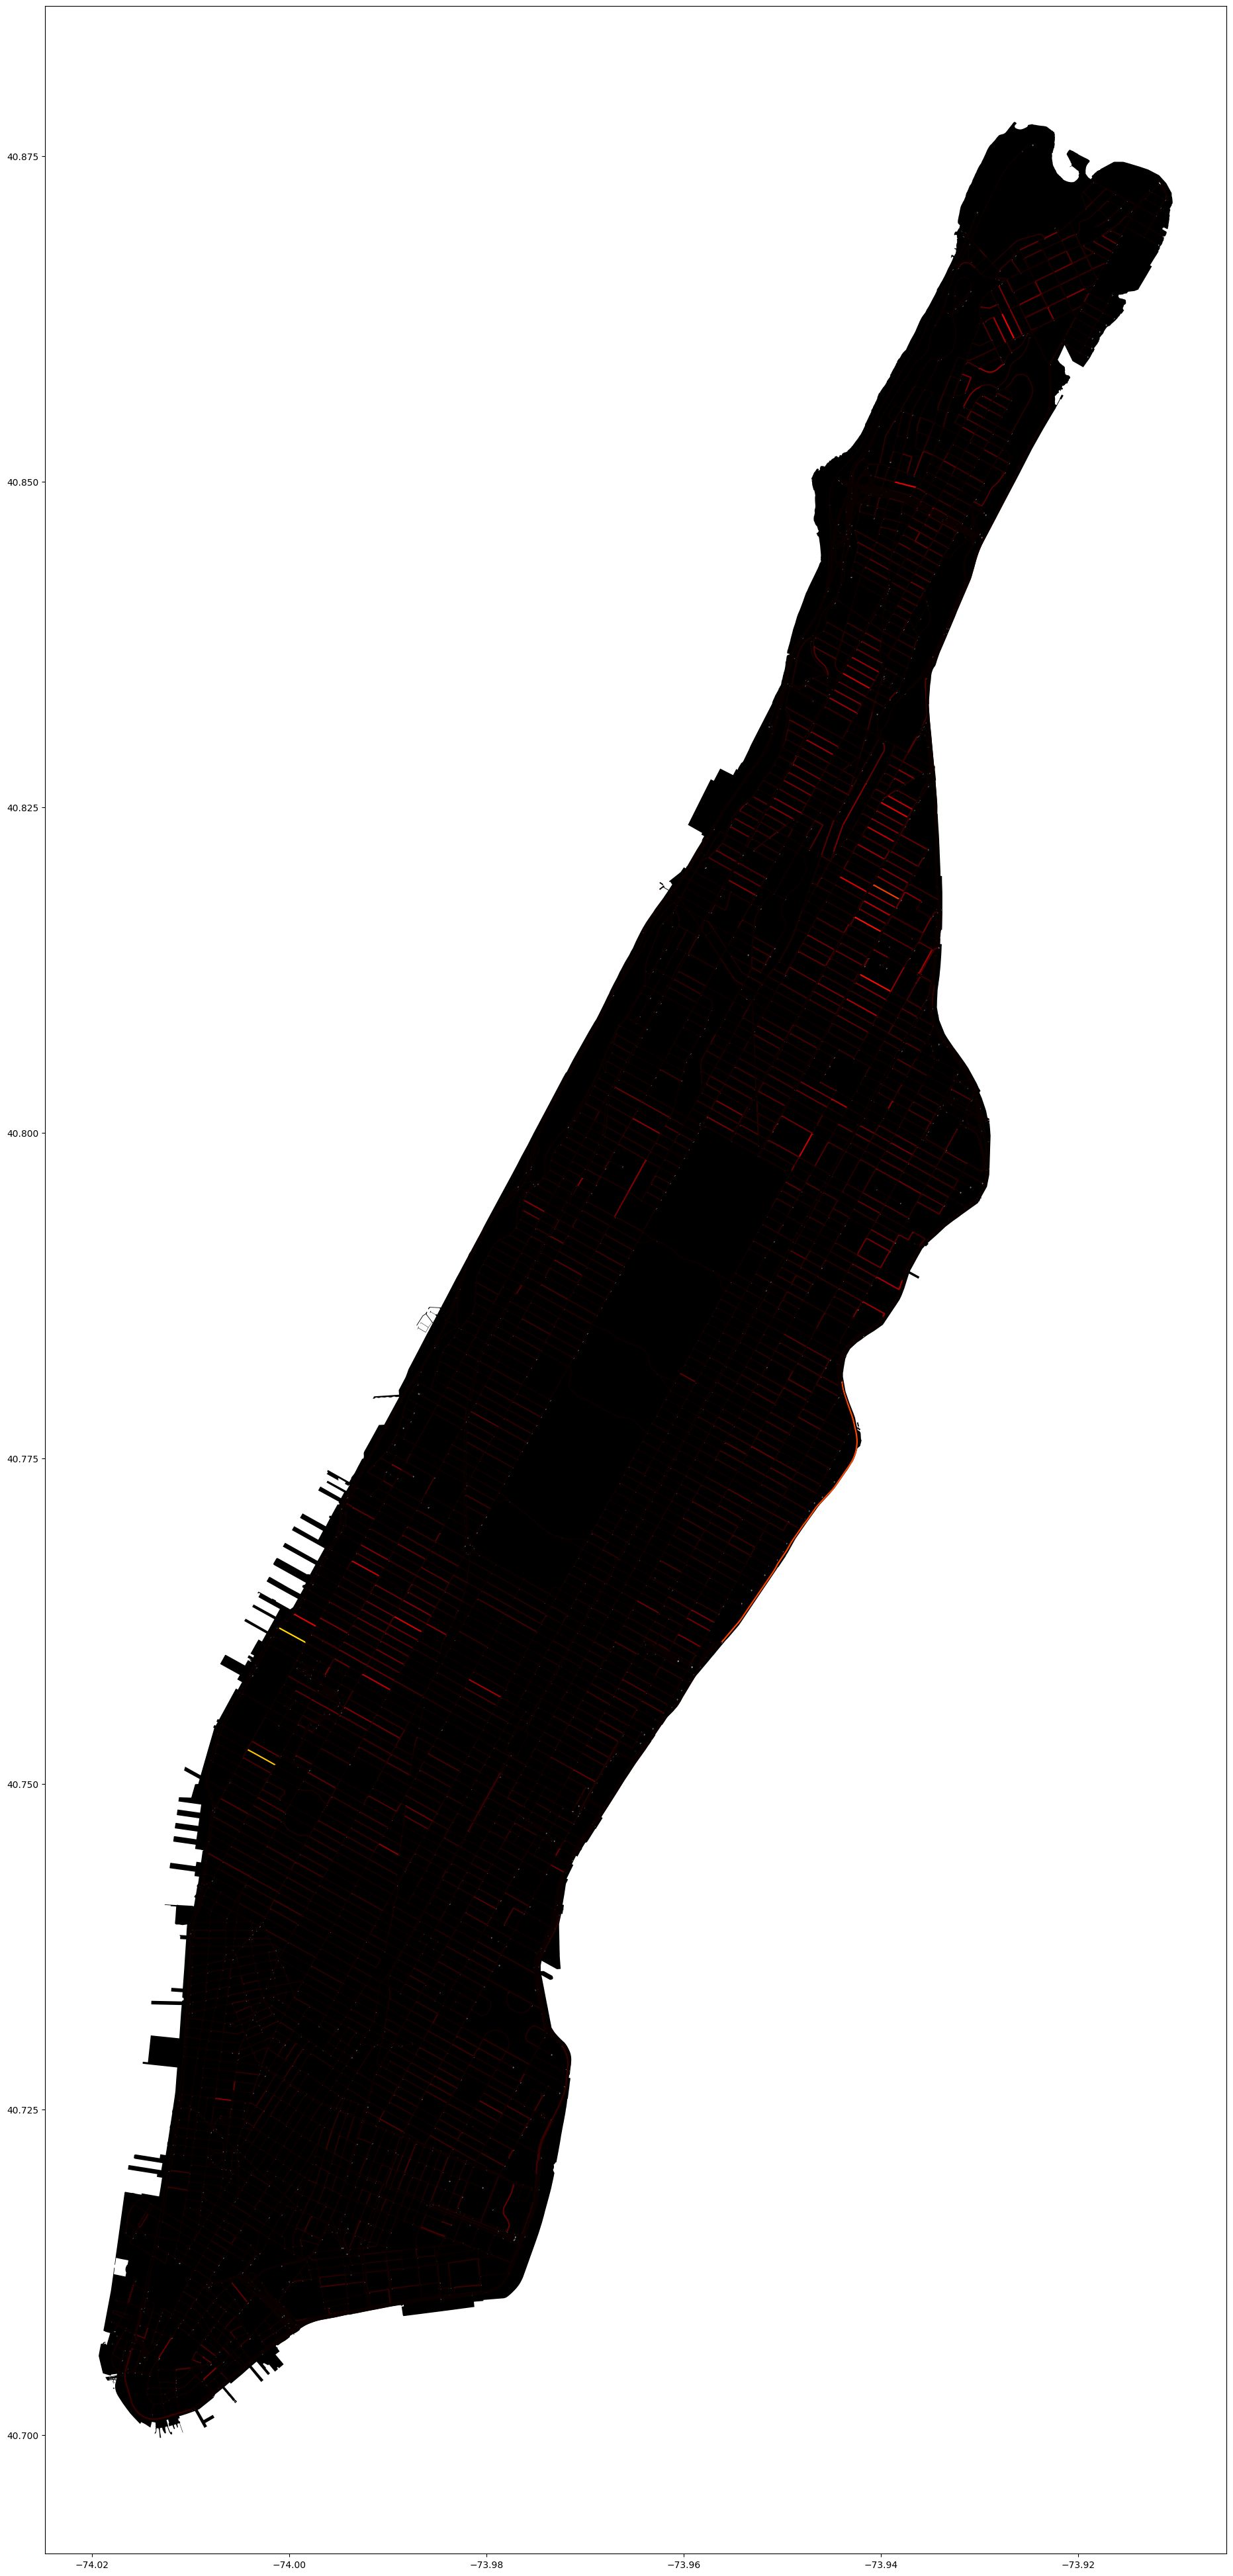

In [80]:
fig, ax = plt.subplots(figsize=(30,50))
area.plot(ax = ax, facecolor = 'black')
edges.plot(ax = ax, column = 'evictions', cmap = 'hot', linewidth = 1.5)
nodes.plot(ax= ax, color = 'white', markersize = .1)
# property_gdf.plot(ax= ax,  markersize = 0.5, color = 'blue')

plt.show()

#### FEATURE 2: PROPERTY VALUE

In [81]:
property_data = open(r'H:\03_AIA\01_GRAPHML\cleaned_property_data.csv')
property_df = pd.read_csv(property_data)


c:\Users\jfoo\AppData\Local\miniconda3\envs\graphml\lib\site-packages\IPython\core\interactiveshell.py:3508: DtypeWarning: Columns (1,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [82]:
geometry = gpd.points_from_xy(property_df['Longitude'], property_df['Latitude'])
property_gdf = gpd.GeoDataFrame(property_df, geometry= geometry)
property_gdf.set_crs(epsg= 4326)

Unnamed: 0        BBLE  BORO  BLOCK   LOT EASEMENT  \
0              3514  1009281654     1    928  1654      NaN   
1              3519  1009281661     1    928  1661      NaN   
2              3544  1010511417     1   1051  1417      NaN   
3              7066  1006371201     1    637  1201      NaN   
4             10598  1002791006     1    279  1006      NaN   
...             ...         ...   ...    ...   ...      ...   
1341054     8925107  1019480024     1   1948    24      NaN   
1341055     8925108  1021440003     1   2144     3      NaN   
1341056     8925110  1021410029     1   2141    29      NaN   
1341057     8925111  1020251006     1   2025  1006      NaN   
1341058     8925112  1021100018     1   2110    18      NaN   

                         OWNER BLDGCL TAXCLASS  LTFRONT  ...    Borough  \
0                          NaN     R4        2        0  ...  MANHATTAN   
1                          NaN     R4        2        0  ...  MANHATTAN   
2                          NaN     R4        2        0  ...  MANHATTAN   
3                          NaN     R8       2C        0  ...  MANHATTAN   
4                  U CHOI WONG     R1       2C        0  ...  MANHATTAN   
...                        ...    ...      ...      ...  ...        ...   
1341054  510 MANHATTAN AFFORDA     G7        4       25  ...  MANHATTAN   
1341055  45 & 47 WADWORTH AVEN     I9        4       50  ...  MANHATTAN   
1341056        THE ASCONIA LLC     D7        2      139  ...  MANHATTAN   
1341057  VAZQUEZ, DANIEL CASAN     R2        2       72  ...  MANHATTAN   
1341058  432-434 WEST 163RD ST     C1        2       50  ...  MANHATTAN   

          Latitude  Longitude  Community Board  Council District  \
0        40.736451 -73.978732            106.0               2.0   
1        40.736451 -73.978732            106.0               2.0   
2        40.759212 -73.994510            104.0               3.0   
3        40.735330 -74.009670            102.0               3.0   
4        40.712189 -73.997843            103.0               1.0   
...            ...        ...              ...               ...   
1341054  40.807889 -73.953676            110.0               9.0   
1341055  40.846186 -73.937623            112.0              10.0   
1341056  40.843846 -73.938775            112.0              10.0   
1341057  40.818687 -73.941926            110.0               9.0   
1341058  40.835993 -73.938142            112.0              10.0   

         Census Tract        BIN                                NTA  \
0                64.0  1086124.0                           Gramercy   
1                64.0  1086124.0                           Gramercy   
2               115.0  1088437.0                            Clinton   
3                75.0  1012003.0                       West Village   
4                27.0  1003389.0                          Chinatown   
...               ...        ...                                ...   
1341054         257.0  1000000.0               Central Harlem South   
1341055         263.0  1089928.0           Washington Heights South   
1341056         253.0  1063463.0           Washington Heights South   
1341057         230.0  1060373.0  Central Harlem North-Polo Grounds   
1341058       24301.0  1062592.0           Washington Heights South   

             New Georeferenced Column                    geometry  
0        POINT (-73.978732 40.736451)  POINT (-73.97873 40.73645)  
1        POINT (-73.978732 40.736451)  POINT (-73.97873 40.73645)  
2         POINT (-73.99451 40.759212)  POINT (-73.99451 40.75921)  
3          POINT (-74.00967 40.73533)  POINT (-74.00967 40.73533)  
4        POINT (-73.997843 40.712189)  POINT (-73.99784 40.71219)  
...                               ...                         ...  
1341054  POINT (-73.953676 40.807889)  POINT (-73.95368 40.80789)  
1341055  POINT (-73.937623 40.846186)  POINT (-73.93762 40.84619)  
1341056  POINT (-73.938775 40.843846)  POINT (-73.93878 40.84385)  
1

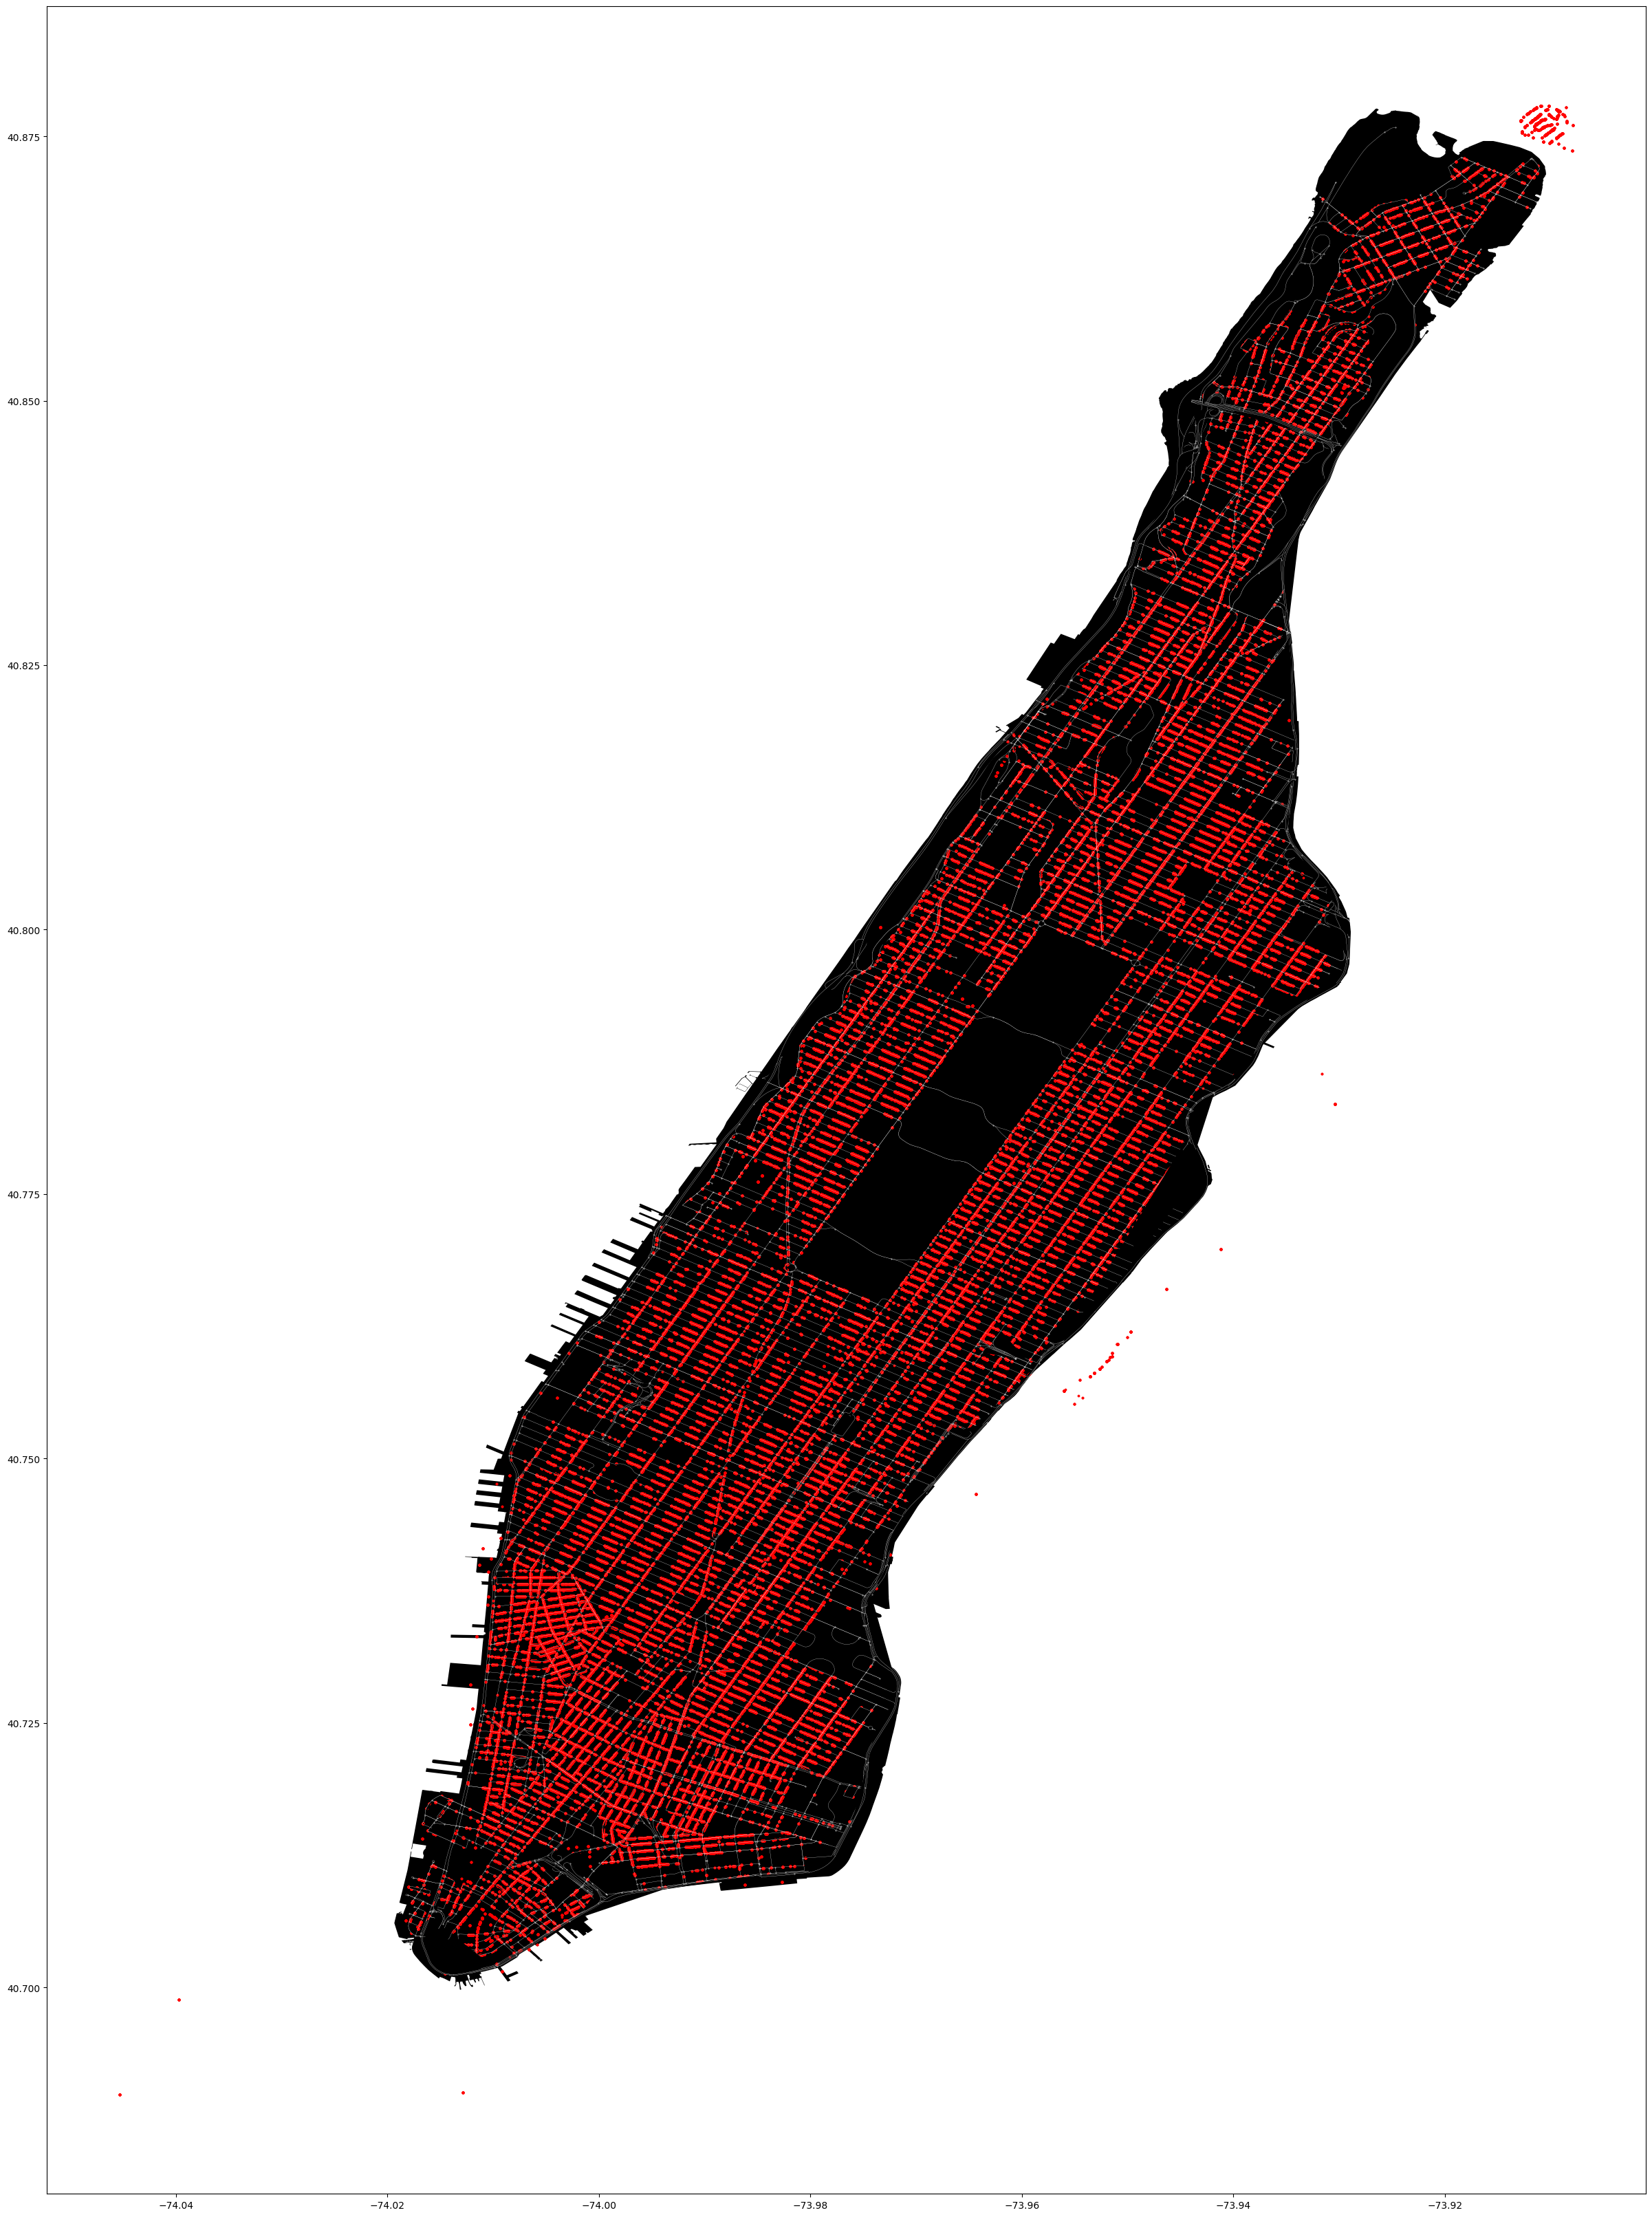

In [83]:
property_gdf_points = property_gdf[property_gdf['geometry'].type == 'Point']

fig, ax = plt.subplots(figsize=(30,50))
area.plot(ax = ax, facecolor = 'black')
edges.plot(ax = ax, linewidth = 0.2, edgecolor = 'white', facecolor = 'black')
nodes.plot(ax= ax, color = 'white', markersize = .1)
property_gdf_points.plot(ax= ax, markersize = 3, color = 'red')

plt.show()

In [84]:
nearest_edges = ox.distance.nearest_edges(G, property_gdf['geometry'].x, property_gdf['geometry'].y)
edge_values = {edge: [] for edge in nearest_edges}

In [85]:
for i, edge in enumerate(nearest_edges):
    edge_values[edge].append(property_gdf.iloc[i]['AVTOT'])

In [86]:
# print(list(islice(edge_values.items(), 1)))

In [87]:
for edge, values in edge_values.items():
    avg_value = np.mean(values)
    print(avg_value)
    u, v, key = edge
    edges.loc[(u,v,key), 'Average Value'] = avg_value

edges = edges.fillna(0)

548511.1117647059
834887.9142857143
132138.68347338936
189441.25490196078
749317.5384615385
389836.35931558936
145630.38522012578
475267.89858490566
112886.8525648415
153280.16358641358
125159.3289657095
475653.9603960396
618225.2037037037
202416.28265107214
24901257.583333332
202694.46506024097
975239.3174603175
125546.21519795658
204391.97695218437
1278060.139497595
206469.70316693504
223284.76388888888
533026.873385013
147525.67336860672
452317.6759259259
227260.78289962825
244508.08408796895
117517.71028806585
72748.09315375982
289822.0189393939
282185.5181008902
97801.08728652752
343875.8888888889
249204.59081836327
780495.7654320988
131325.01880341882
222880.4513847967
119668.31573157315
807219.1560102302
684699.9569789675
223670.6888888889
98132.30202020203
807617.117820324
626092.1811175337
2713570.0
174234.10014947684
2436052.2027027025
222172.90571049138
173940.99881446356
95556.8499756454
229644.43901035673
700492.344262295
442216.5664451827
317047.09882352944
1881624.578853

In [88]:
from sklearn.preprocessing import StandardScaler
value_scaler = StandardScaler()

edges['Scaled Value'] = value_scaler.fit_transform(np.array(edges['Average Value']).reshape(-1,1))

(array([9.013e+03, 3.330e+02, 1.310e+02, 6.000e+01, 4.000e+01, 2.200e+01,
        2.100e+01, 1.500e+01, 1.700e+01, 1.100e+01, 4.000e+00, 4.000e+00,
        5.000e+00, 5.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 4.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

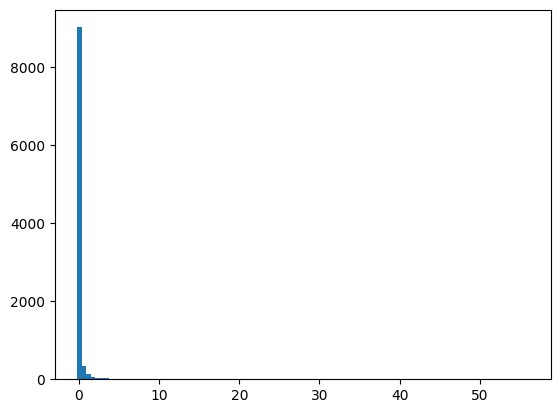

In [89]:
plt.hist(edges['Scaled Value'], bins=100)

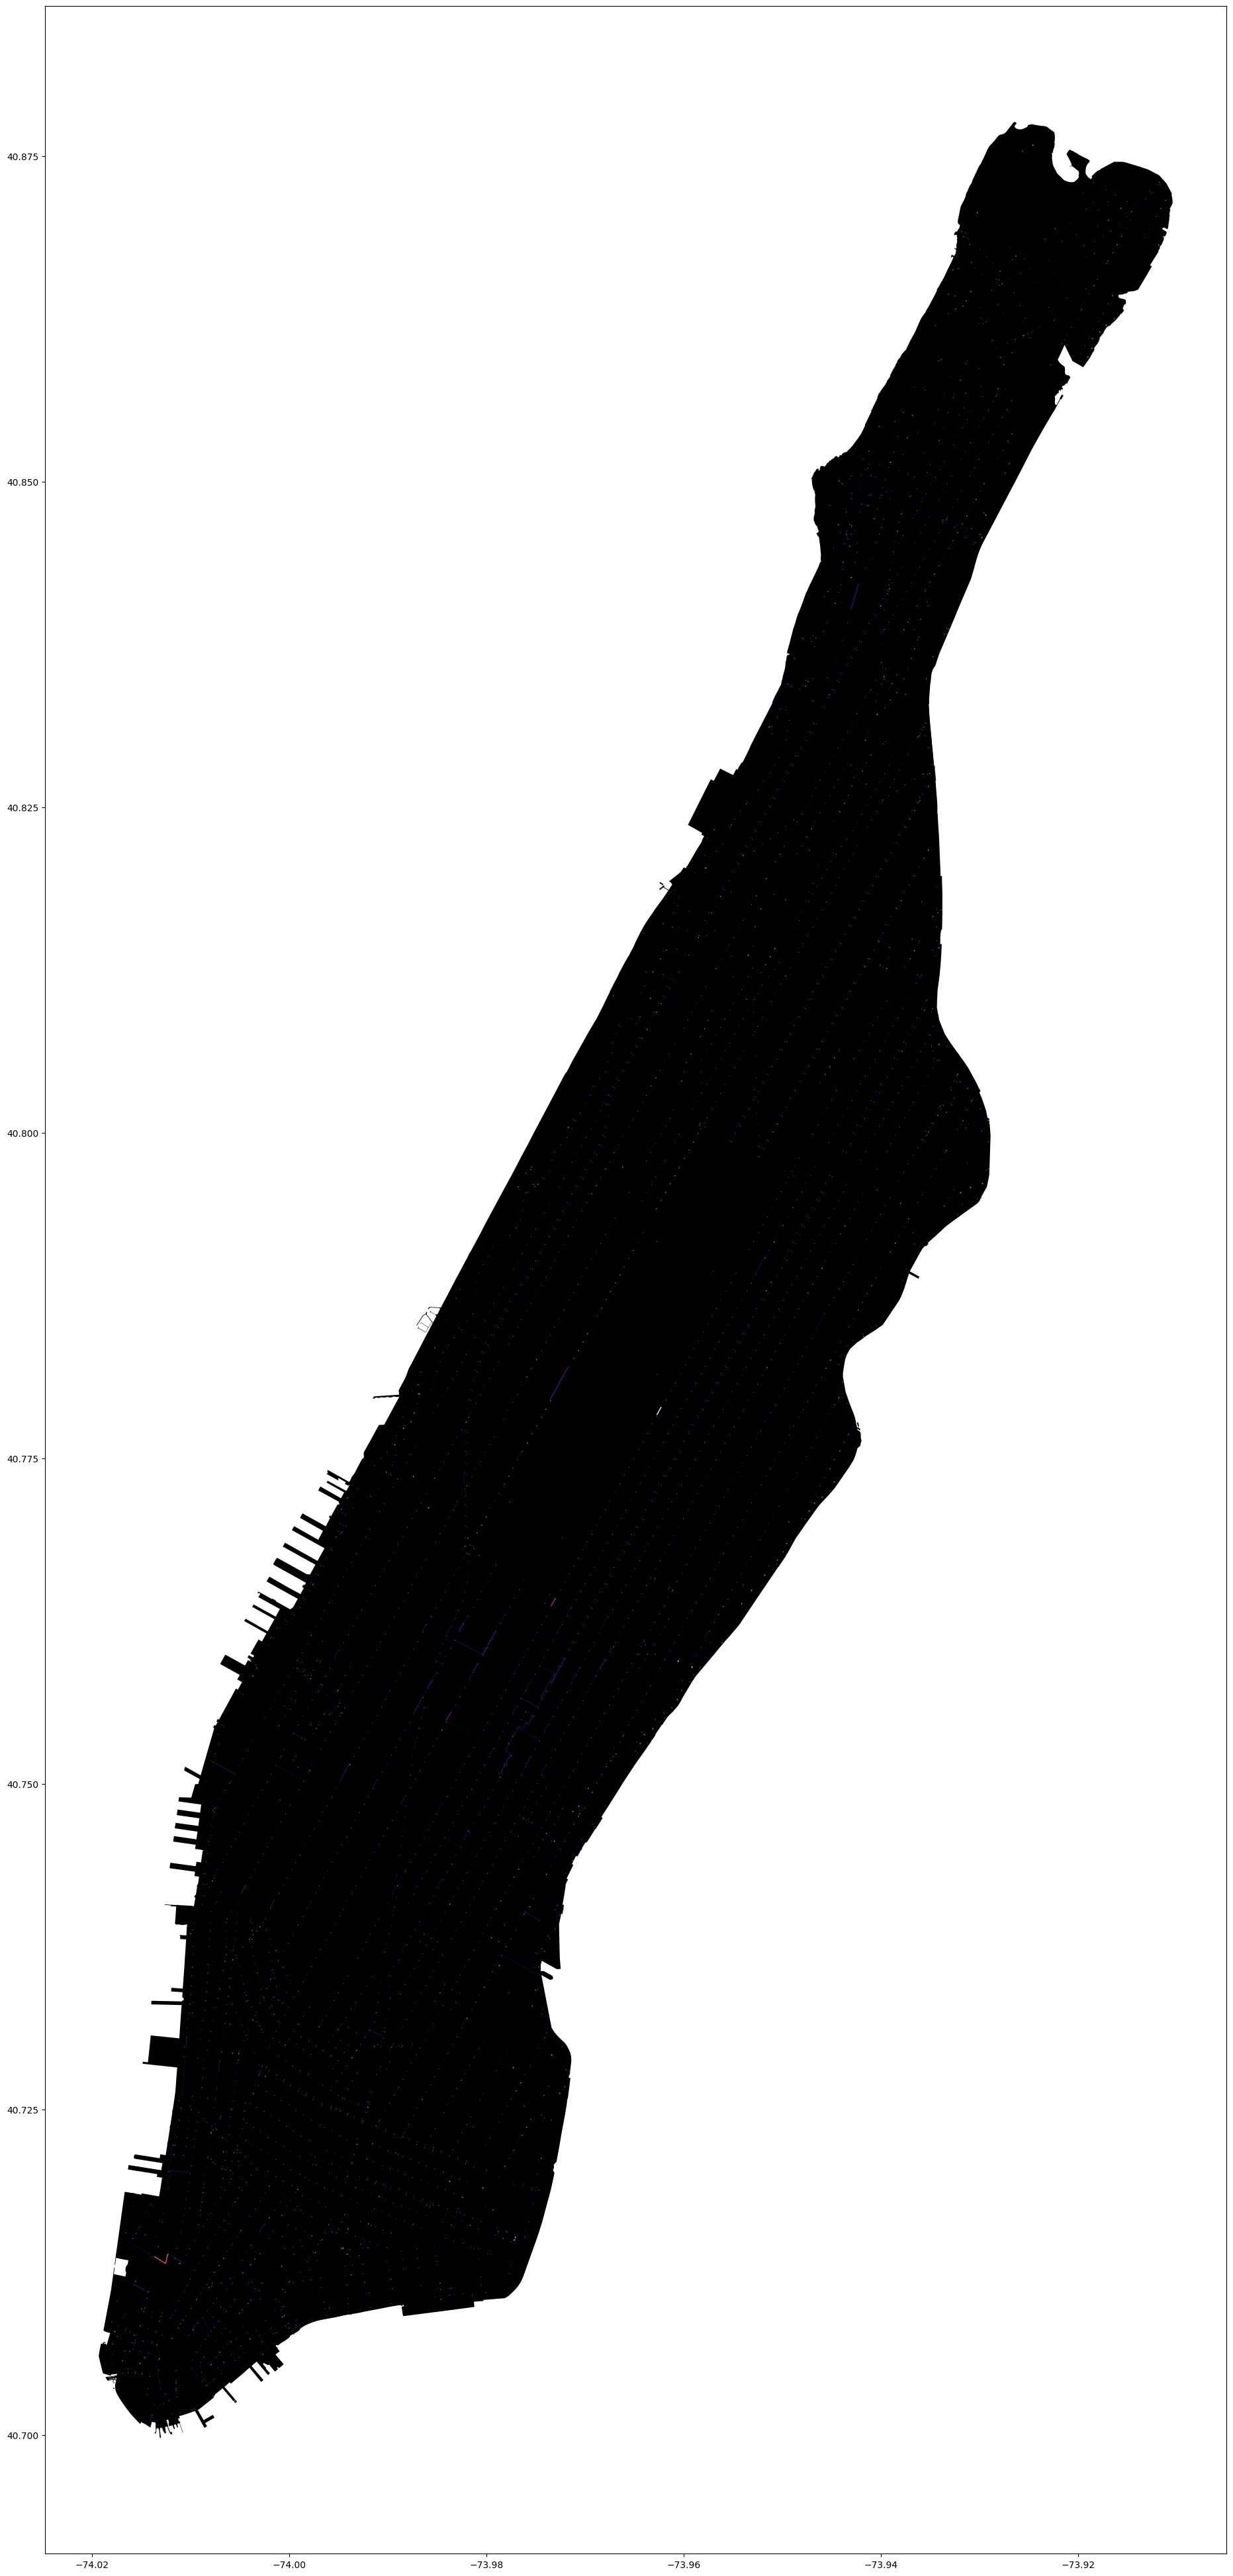

In [90]:
fig, ax = plt.subplots(figsize=(30,50))
area.plot(ax = ax, facecolor = 'black')
edges.plot(ax = ax, column = 'Scaled Value', cmap = 'magma', linewidth = 1)
nodes.plot(ax= ax, color = 'white', markersize = .1)
# property_gdf.plot(ax= ax,  markersize = 0.5, color = 'blue')

plt.show()

#### FEATURE 3: HOUSING PROJECTS SINCE 2010

In [108]:
construction_data = open(r'C:\Users\jfoo\OneDrive - tvsdesign\Desktop\MACAD\AIA\Studio\AIA-GML-James-Andres\Data\HousingDB_post2010.csv')
construction_df = pd.read_csv(construction_data)
manhattan_construction = construction_df[construction_df['Boro']==1]
clean_construction = manhattan_construction.dropna(subset = ['Latitude'])
clean_construction.head()

Job_Number    Job_Type    ResidFlag       NonresFlag  \
0  102133451  Alteration  Residential              NaN   
1  102138820  Alteration  Residential              NaN   
2  102151083  Alteration  Residential              NaN   
3  102284172  Alteration  Residential  Non-Residential   
4  102284804  Alteration  Residential              NaN   

                      Job_Status  CompltYear  PermitYear  ClassAInit  \
0  3. Permitted for Construction         NaN      2003.0           8   
1      5. Completed Construction      2012.0      2008.0           6   
2      5. Completed Construction      2011.0      2002.0           7   
3      5. Completed Construction      2016.0      2001.0           1   
4      5. Completed Construction      2022.0      2001.0           4   

   ClassAProp  ClassANet  ...  FireBattln  FireDivsn  PolicePcnt  PL_FIRM07  \
0           8          0  ...         1.0        1.0         1.0        NaN   
1          19         13  ...        11.0        3.0        24.0        NaN   
2           9          2  ...         4.0        1.0         9.0        NaN   
3           1          0  ...         6.0        1.0         9.0        NaN   
4           4          0  ...         6.0        1.0         6.0        NaN   

   PL_PFIRM15   Latitude  Longitude                  GeomSource  \
0         NaN  40.719845 -74.009588  BIN DOB buildingfootprints   
1         NaN  40.796741 -73.962554  BIN DOB buildingfootprints   
2         NaN  40.722545 -73.982291  BIN DOB buildingfootprints   
3         NaN  40.726385 -73.992369  BIN DOB buildingfootprints   
4         NaN  40.728763 -74.000817  BIN DOB buildingfootprints   

                                           DCPEdited Version  
0  otherb_init/hotel_init/hotel_prop/otherb_prop/...    23Q4  
1  otherb_init/hotel_prop/otherb_prop/hotel_init/...    23Q4  
2                                                NaN    23Q4  
3                                        classa_init    23Q4  
4  hotel_prop/hotel_init/classa_init/otherb_init/...    23Q4  

[5 rows x 63 columns]

In [111]:
construction_geometry = gpd.points_from_xy(clean_construction['Longitude'], clean_construction['Latitude'])
construction_gdf = gpd.GeoDataFrame(clean_construction, geometry = construction_geometry)
construction_gdf.set_crs(epsg = 4326)
# new_construction = construction_gdf[construction_gdf['Job_Type'] == 'New Building']

Job_Number      Job_Type    ResidFlag       NonresFlag  \
0      102133451    Alteration  Residential              NaN   
1      102138820    Alteration  Residential              NaN   
2      102151083    Alteration  Residential              NaN   
3      102284172    Alteration  Residential  Non-Residential   
4      102284804    Alteration  Residential              NaN   
...          ...           ...          ...              ...   
69351  M08055337    Alteration  Residential  Non-Residential   
69352  M08055390    Alteration  Residential              NaN   
69353  M08055506    Alteration  Residential              NaN   
74632  X00633905  New Building  Residential  Non-Residential   
75059  X00837726    Alteration  Residential              NaN   

                          Job_Status  CompltYear  PermitYear  ClassAInit  \
0      3. Permitted for Construction         NaN      2003.0           8   
1          5. Completed Construction      2012.0      2008.0           6   
2          5. Completed Construction      2011.0      2002.0           7   
3          5. Completed Construction      2016.0      2001.0           1   
4          5. Completed Construction      2022.0      2001.0           4   
...                              ...         ...         ...         ...   
69351        2. Approved Application         NaN         NaN           2   
69352           1. Filed Application         NaN         NaN           6   
69353  3. Permitted for Construction         NaN      2023.0           1   
74632        2. Approved Application         NaN         NaN           0   
75059           1. Filed Application         NaN         NaN           2   

       ClassAProp  ClassANet  ...  FireDivsn  PolicePcnt  PL_FIRM07  \
0               8          0  ...        1.0         1.0        NaN   
1              19         13  ...        3.0        24.0        NaN   
2               9          2  ...        1.0         9.0        NaN   
3               1          0  ...        1.0         9.0        NaN   
4               4          0  ...        1.0         6.0        NaN   
...           ...        ...  ...        ...         ...        ...   
69351           2          0  ...        1.0         9.0        NaN   
69352           6          0  ...        3.0        28.0        NaN   
69353           1          0  ...        3.0        24.0        NaN   
74632         115        115  ...        7.0        50.0        NaN   
75059           2          0  ...        7.0        50.0        NaN   

       PL_PFIRM15   Latitude  Longitude                  GeomSource  \
0             NaN  40.719845 -74.009588  BIN DOB buildingfootprints   
1             NaN  40.796741 -73.962554  BIN DOB buildingfootprints   
2             NaN  40.722545 -73.982291  BIN DOB buildingfootprints   
3             NaN  40.726385 -73.992369  BIN DOB buildingfootprints   
4             NaN  40.728763 -74.000817  BIN DOB buildingfootprints   
...           ...        ...        ...                         ...   
69351         NaN  40.727461 -73.990142  BIN DOB buildingfootprints   
69352         NaN  40.804428 -73.948899  BIN DOB buildingfootprints   
69353         NaN  40.790582 -73.978352  BIN DOB buildingfootprints   
74632         NaN  40.875608 -73.913097          Lat/Lon geosupport   
75059         NaN  40.876426 -73.911286  BIN DOB buildingfootprints   

                                               DCPEdited Version  \
0      otherb_init/hotel_init/hotel_prop/otherb_prop/...    23Q4   
1      otherb_init/hotel_prop/otherb_prop/hotel_init/...    23Q4   
2                                                    NaN    23Q4   
3                                            classa_init    23Q4   
4      hotel_prop/hotel_init/classa_init/otherb_init/...    23Q4   
...                                                  ...     ...   
69351                                                NaN    23Q4   
69352                                                NaN    23Q4   
69353 

In [112]:
construction_points = construction_gdf[construction_gdf['geometry'].type == 'Point']
construction_points.head()

Job_Number    Job_Type    ResidFlag       NonresFlag  \
0  102133451  Alteration  Residential              NaN   
1  102138820  Alteration  Residential              NaN   
2  102151083  Alteration  Residential              NaN   
3  102284172  Alteration  Residential  Non-Residential   
4  102284804  Alteration  Residential              NaN   

                      Job_Status  CompltYear  PermitYear  ClassAInit  \
0  3. Permitted for Construction         NaN      2003.0           8   
1      5. Completed Construction      2012.0      2008.0           6   
2      5. Completed Construction      2011.0      2002.0           7   
3      5. Completed Construction      2016.0      2001.0           1   
4      5. Completed Construction      2022.0      2001.0           4   

   ClassAProp  ClassANet  ...  FireDivsn  PolicePcnt  PL_FIRM07  PL_PFIRM15  \
0           8          0  ...        1.0         1.0        NaN         NaN   
1          19         13  ...        3.0        24.0        NaN         NaN   
2           9          2  ...        1.0         9.0        NaN         NaN   
3           1          0  ...        1.0         9.0        NaN         NaN   
4           4          0  ...        1.0         6.0        NaN         NaN   

    Latitude  Longitude                  GeomSource  \
0  40.719845 -74.009588  BIN DOB buildingfootprints   
1  40.796741 -73.962554  BIN DOB buildingfootprints   
2  40.722545 -73.982291  BIN DOB buildingfootprints   
3  40.726385 -73.992369  BIN DOB buildingfootprints   
4  40.728763 -74.000817  BIN DOB buildingfootprints   

                                           DCPEdited Version  \
0  otherb_init/hotel_init/hotel_prop/otherb_prop/...    23Q4   
1  otherb_init/hotel_prop/otherb_prop/hotel_init/...    23Q4   
2                                                NaN    23Q4   
3                                        classa_init    23Q4   
4  hotel_prop/hotel_init/classa_init/otherb_init/...    23Q4   

                     geometry  
0  POINT (-74.00959 40.71984)  
1  POINT (-73.96255 40.79674)  
2  POINT (-73.98229 40.72254)  
3  POINT (-73.99237 40.72639)  
4  POINT (-74.00082 40.72876)  

[5 rows x 64 columns]

<Axes: >

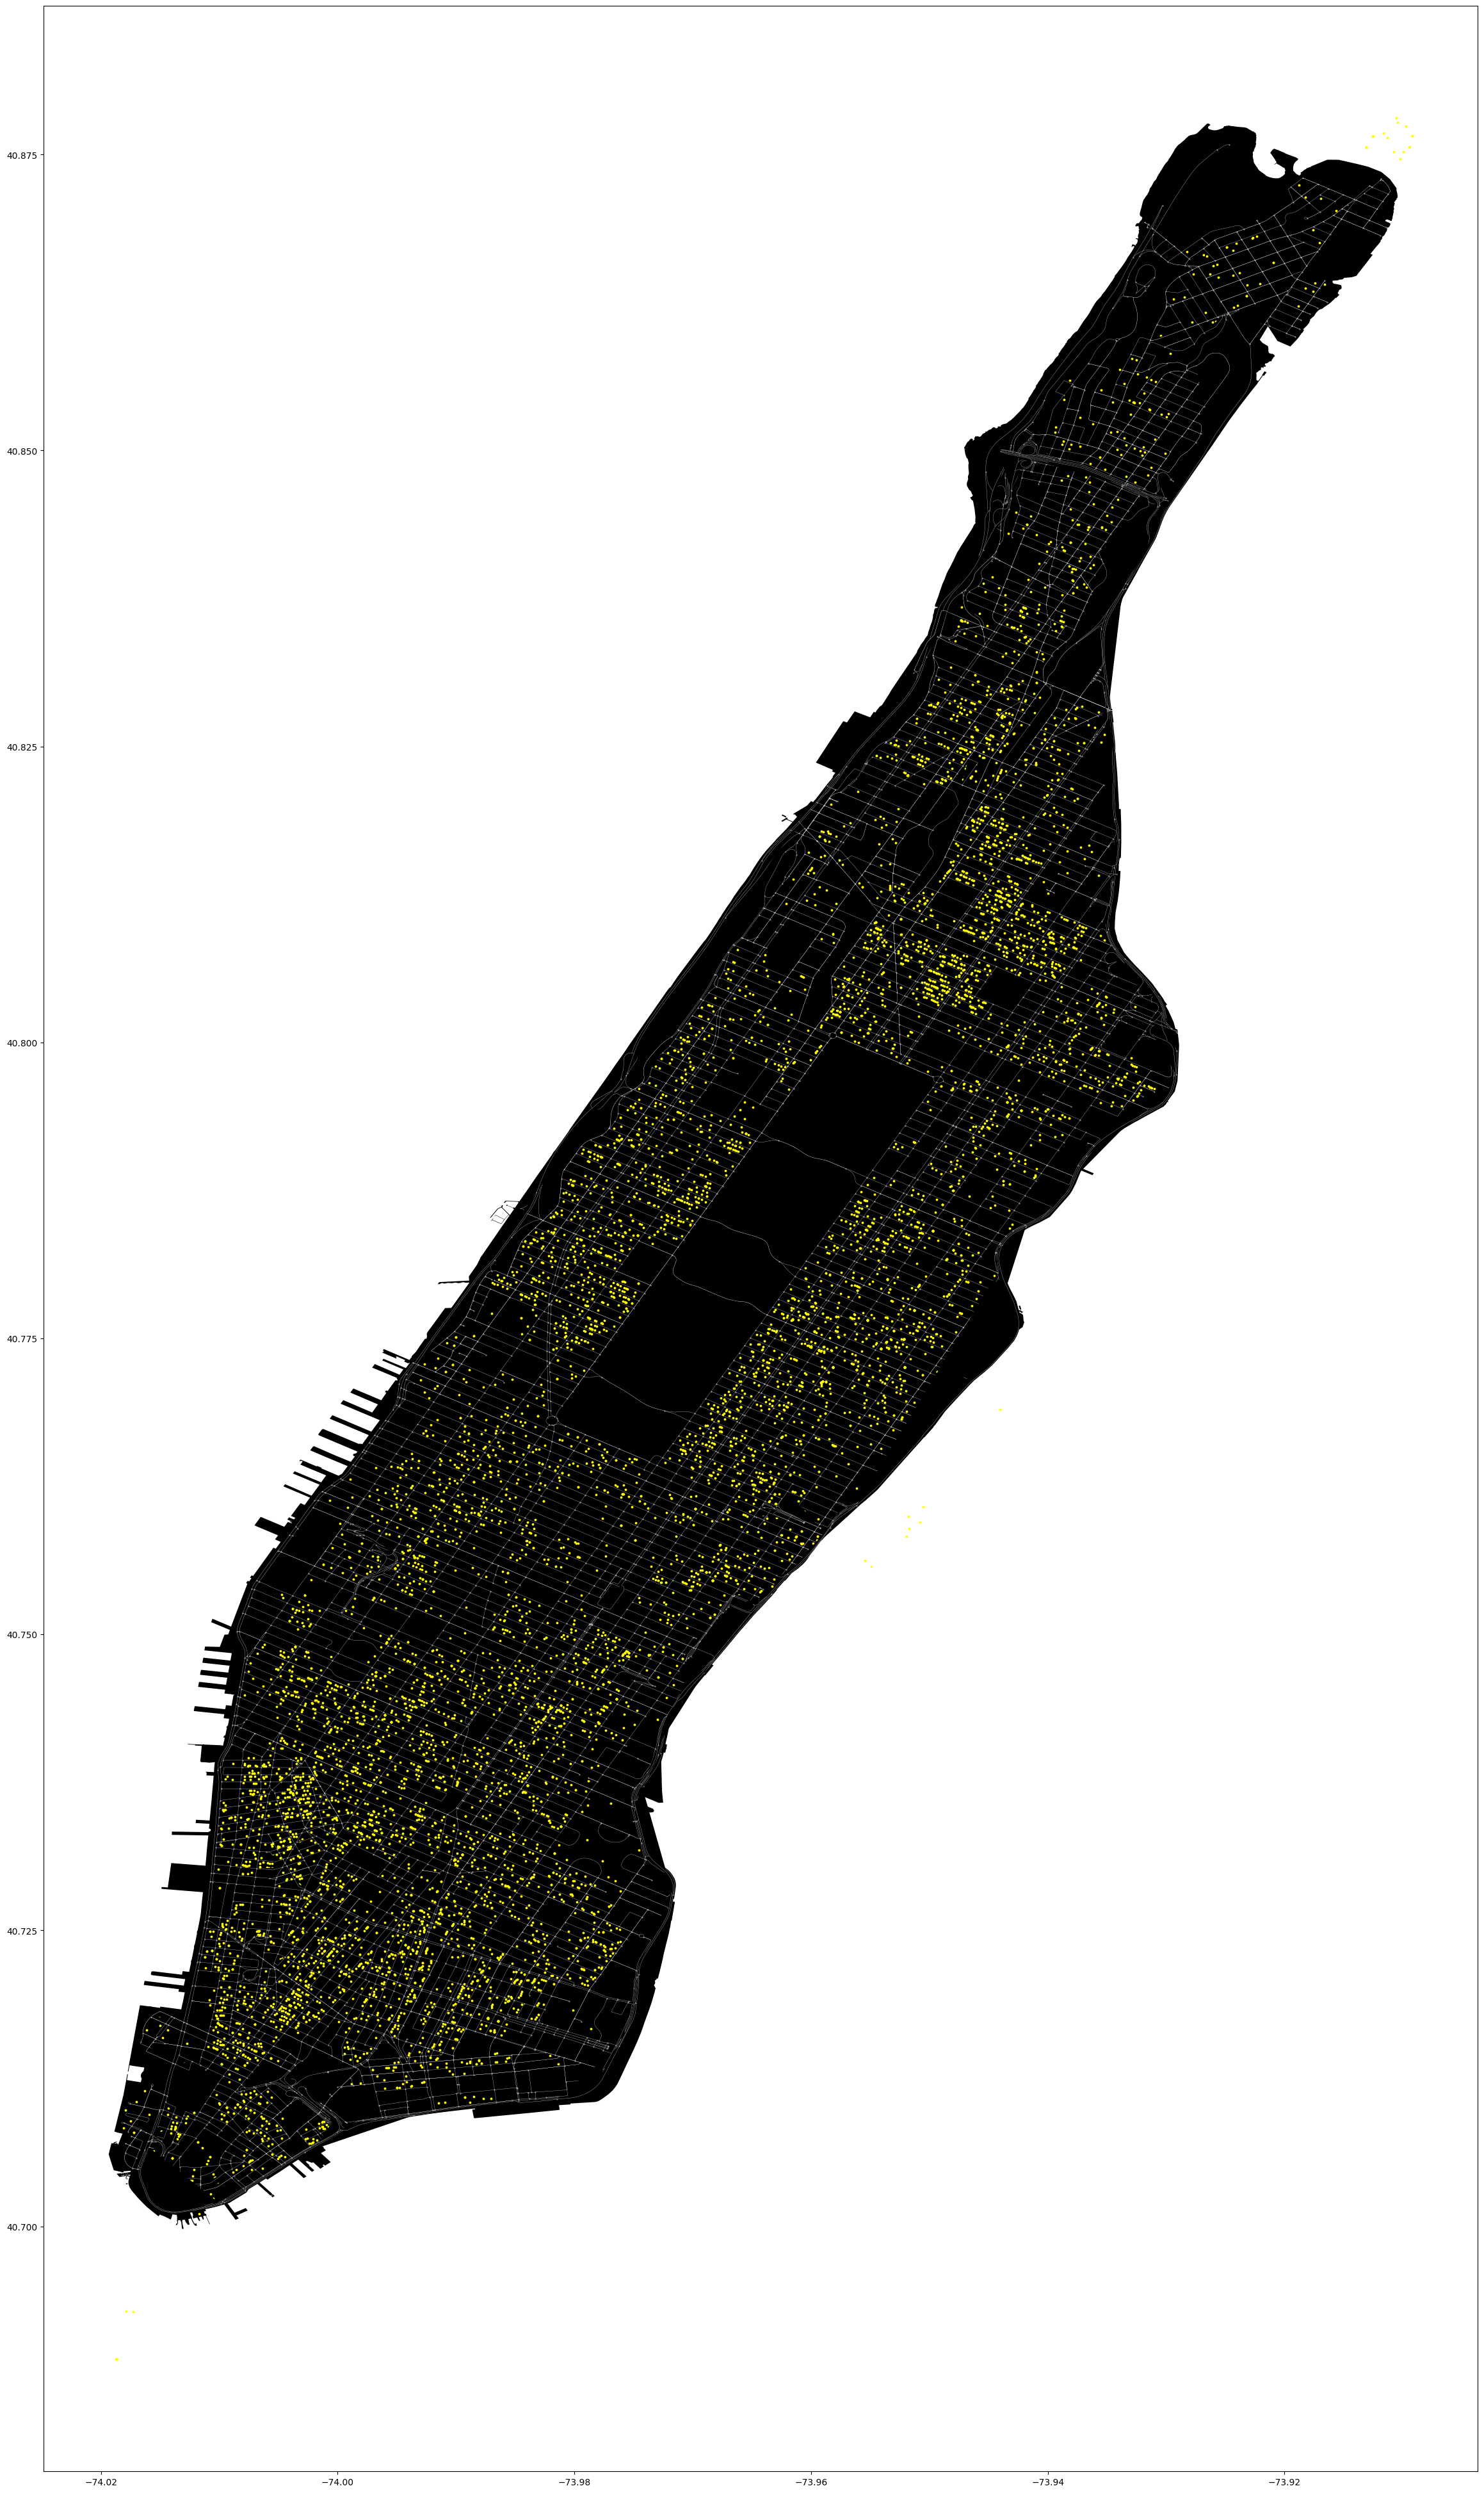

In [113]:
fig, ax = plt.subplots(figsize=(30,50))
area.plot(ax = ax, facecolor = 'black')
edges.plot(ax = ax, linewidth = 0.2, edgecolor = 'white', facecolor = 'black')
nodes.plot(ax= ax, color = 'white', markersize = .1)
construction_points.plot(ax= ax, markersize = 3, color = 'yellow')

In [116]:
close_edges = ox.distance.nearest_edges(G, construction_points['geometry'].x, construction_points['geometry'].y)
construction_count = Counter(close_edges)
new_construction = []

for i in edges.index:
    project = construction_count[edges.loc[i].name]
    new_construction.append(project)


edges['New Construction'] = new_construction

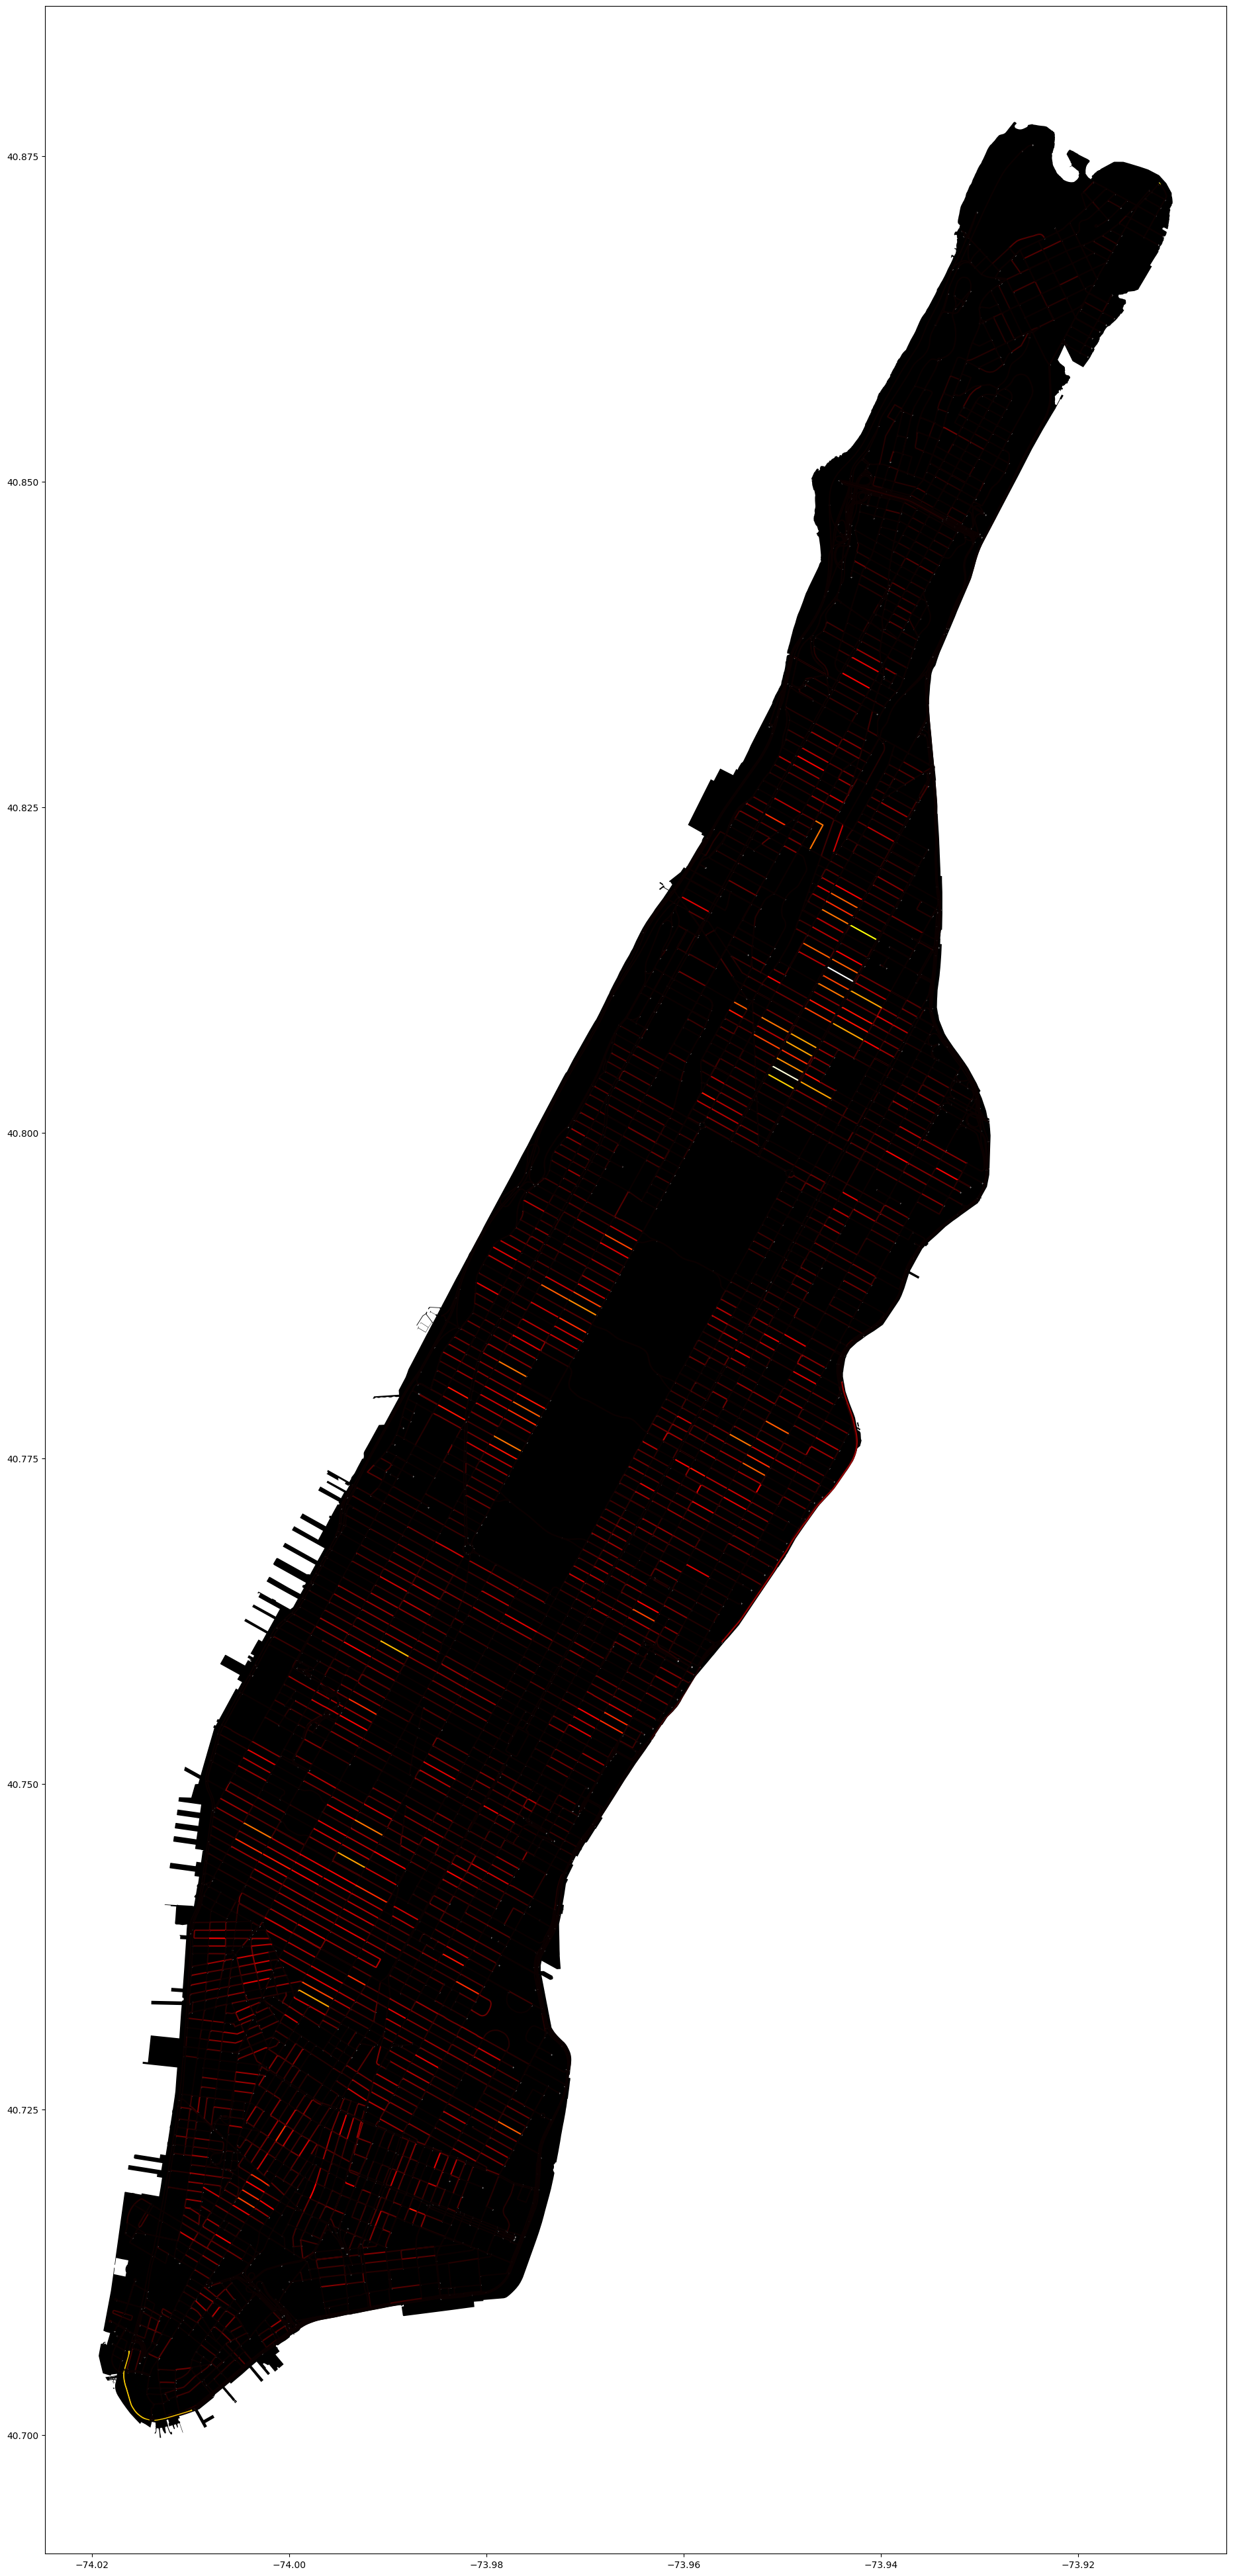

In [118]:
fig, ax = plt.subplots(figsize=(30,50))
area.plot(ax = ax, facecolor = 'black')
edges.plot(ax = ax, column = 'New Construction', cmap = 'hot', linewidth = 1.5)
nodes.plot(ax= ax, color = 'white', markersize = .1)
# property_gdf.plot(ax= ax,  markersize = 0.5, color = 'blue')

plt.show()

#### FEATURE ANALYSIS

In [91]:
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns
import warnings

In [119]:
edges.head()

osmid               name  \
u        v        key                                                       
42421728 42435337 0                          195743153  Central Park West   
         42421731 0    [420625565, 420625573, 5668966]  West 106th Street   
         42432736 0           [1271523197, 1271523198]  Central Park West   
42435337 42437916 0                            5670640  West 105th Street   
         42421728 0                          195743153  Central Park West   

                           highway maxspeed  oneway reversed   length  \
u        v        key                                                   
42421728 42435337 0      secondary   25 mph   False     True   85.345   
         42421731 0      secondary        0   False    False  138.033   
         42432736 0      secondary   25 mph   False    False   86.274   
42435337 42437916 0    residential   25 mph    True    False  137.996   
         42421728 0      secondary   25 mph   False    False   85.345   

                                                                geometry  \
u        v        key                                                      
42421728 42435337 0    LINESTRING (-73.96004 40.79805, -73.96011 40.7...   
         42421731 0    LINESTRING (-73.96004 40.79805, -73.96017 40.7...   
         42432736 0    LINESTRING (-73.96004 40.79805, -73.95996 40.7...   
42435337 42437916 0    LINESTRING (-73.96053 40.79738, -73.96065 40.7...   
         42421728 0    LINESTRING (-73.96053 40.79738, -73.96049 40.7...   

                      lanes ref access bridge tunnel width junction  \
u        v        key                                                 
42421728 42435337 0       0   0      0      0      0     0        0   
         42421731 0       0   0      0      0      0     0        0   
         42432736 0       0   0      0      0      0     0        0   
42435337 42437916 0       1   0      0      0      0     0        0   
         42421728 0       0   0      0      0      0     0        0   

                       evictions  Average Value  Scaled Value  \
u        v        key                                           
42421728 42435337 0            0       0.000000     -0.194316   
         42421731 0            3  407507.777778     -0.179722   
         42432736 0            1       0.000000     -0.194316   
42435337 42437916 0            3  107759.857143     -0.190457   
         42421728 0            0  146891.866887     -0.189055   

                       New Construction  
u        v        key                    
42421728 42435337 0                   0  
         42421731 0                   0  
         42432736 0                   0  
42435337 42437916 0                   0  
         42421728 0                   0

interval columns not set, guessing: ['Scaled Value', 'evictions', 'New Construction']


Text(0.5, 1.0, 'Correlation Heatmap')

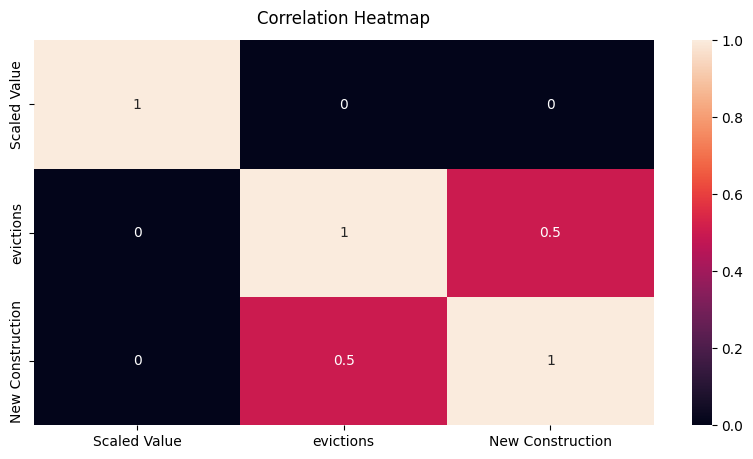

In [120]:
attributes_to_check = ['Scaled Value', 'evictions', 'New Construction']
data_to_check = edges[attributes_to_check]
warnings.filterwarnings("ignore")

plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(data_to_check.phik_matrix(), annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

#### ADD DATA TO NODES
Finds the average value of all connected edges for each node.

In [121]:
G_enriched = ox.graph_from_gdfs(nodes, edges)

In [122]:
edges.head()

osmid               name  \
u        v        key                                                       
42421728 42435337 0                          195743153  Central Park West   
         42421731 0    [420625565, 420625573, 5668966]  West 106th Street   
         42432736 0           [1271523197, 1271523198]  Central Park West   
42435337 42437916 0                            5670640  West 105th Street   
         42421728 0                          195743153  Central Park West   

                           highway maxspeed  oneway reversed   length  \
u        v        key                                                   
42421728 42435337 0      secondary   25 mph   False     True   85.345   
         42421731 0      secondary        0   False    False  138.033   
         42432736 0      secondary   25 mph   False    False   86.274   
42435337 42437916 0    residential   25 mph    True    False  137.996   
         42421728 0      secondary   25 mph   False    False   85.345   

                                                                geometry  \
u        v        key                                                      
42421728 42435337 0    LINESTRING (-73.96004 40.79805, -73.96011 40.7...   
         42421731 0    LINESTRING (-73.96004 40.79805, -73.96017 40.7...   
         42432736 0    LINESTRING (-73.96004 40.79805, -73.95996 40.7...   
42435337 42437916 0    LINESTRING (-73.96053 40.79738, -73.96065 40.7...   
         42421728 0    LINESTRING (-73.96053 40.79738, -73.96049 40.7...   

                      lanes ref access bridge tunnel width junction  \
u        v        key                                                 
42421728 42435337 0       0   0      0      0      0     0        0   
         42421731 0       0   0      0      0      0     0        0   
         42432736 0       0   0      0      0      0     0        0   
42435337 42437916 0       1   0      0      0      0     0        0   
         42421728 0       0   0      0      0      0     0        0   

                       evictions  Average Value  Scaled Value  \
u        v        key                                           
42421728 42435337 0            0       0.000000     -0.194316   
         42421731 0            3  407507.777778     -0.179722   
         42432736 0            1       0.000000     -0.194316   
42435337 42437916 0            3  107759.857143     -0.190457   
         42421728 0            0  146891.866887     -0.189055   

                       New Construction  
u        v        key                    
42421728 42435337 0                   0  
         42421731 0                   0  
         42432736 0                   0  
42435337 42437916 0                   0  
         42421728 0                   0

In [130]:
for node in G_enriched.nodes():
    neighbors = list(G_enriched.neighbors(node))

    if len(neighbors) > 0:
    
        for neighbor in neighbors:

            neighbor_evictions=[]
            neighbor_value = []
            neighbor_construction = []

            neighbor_evictions.append(G_enriched.get_edge_data(node, neighbor)[0]['evictions'])
            neighbor_value.append(G_enriched.get_edge_data(node, neighbor)[0]['Average Value'])
            neighbor_value.append(G_enriched.get_edge_data(node, neighbor)[0]['New Construction'])

            length = len(neighbors)
            avg_evictions = sum(neighbor_evictions)/length
            avg_value = sum(neighbor_value)/length
            avg_construction = sum(neighbor_construction)/length

        G_enriched.nodes[node]['avg_evictions'] = avg_evictions
        G_enriched.nodes[node]['avg_value'] = avg_value
        G_enriched.nodes[node]['avg_construction'] = avg_construction

    else:
        G_enriched.nodes[node]['avg_evictions'] = 0
        G_enriched.nodes[node]['avg_value'] = 0
        G_enriched.nodes[node]['avg_construction'] = 0



In [151]:
nodes, edges = ox.graph_to_gdfs(G_enriched)
nodes['avg_evictions']

osmid
42421728       0.333333
42435337       0.000000
42421731       0.500000
42432736       0.000000
42437916       0.000000
                 ...   
6216836461     1.000000
6331080434     2.000000
9566822907     0.000000
11868048948    0.000000
11868048950    0.000000
Name: avg_evictions, Length: 4501, dtype: float64

### 3. ADD CLASSES
***

In [154]:
classes = []
for node in nodes['avg_evictions']:

    if node > 0 and node <= 5:
        classes.append(1)

    elif node > 5 and node <= 10:
        classes.append(2)
        
    elif node > 10 and node <= 15:
        classes.append(3)
    
    elif node > 15 and node <= 20:
        classes.append(4)
    
    elif node > 20:
        classes.append(5)
    else:
        classes.append(6)


nodes['class'] = classes
nodes.head()

y          x          highway  street_count  avg_evictions  \
osmid                                                                          
42421728  40.798048 -73.960044  traffic_signals             3       0.333333   
42435337  40.797376 -73.960535  traffic_signals             3       0.000000   
42421731  40.798654 -73.961474  traffic_signals             4       0.500000   
42432736  40.798726 -73.959547  traffic_signals             3       0.000000   
42437916  40.797976 -73.961970              NaN             4       0.000000   

             avg_value  proximity_cluster_index  avg_construction  ref  \
osmid                                                                    
42421728  0.000000e+00                        1               0.0  NaN   
42435337  3.143467e+06                        1               0.0  NaN   
42421731  4.219594e+04                        1               0.0  NaN   
42432736  4.201271e+04                        1               0.0  NaN   
42437916  1.661928e+04                        1               0.0  NaN   

                            geometry  class  
osmid                                        
42421728  POINT (-73.96004 40.79805)      1  
42435337  POINT (-73.96053 40.79738)      6  
42421731  POINT (-73.96147 40.79865)      1  
42432736  POINT (-73.95955 40.79873)      6  
42437916  POINT (-73.96197 40.79798)      6

### 4. CREATE DGL GRAPH
***